In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
trainset  = CIFAR10(root='./data', train=True , download=True)
testset   = CIFAR10(root='./data', train=False, download=True)
classDict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))



# Separating trainset/testset data/label
Xtr  = trainset.data
Xte  = testset.data
Ytr  = np.array(trainset.targets)
Yte  = np.array(testset.targets)

# flatten out all images to be one-dimensional
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

# get 2 classes
# As an example plane & cat

unique, counts = np.unique(Ytr, return_counts=True)
count_train = dict(zip(unique, counts))

unique, counts = np.unique(Yte, return_counts=True)
count_test = dict(zip(unique, counts))

###########################################################
Xtr_rows_two = np.zeros(((count_train.get(0)+count_train.get(3)),Xtr_rows.shape[1]),dtype=int)
Xte_rows_two = np.zeros(((count_test.get(0)+count_test.get(3)),Xte_rows.shape[1]),dtype=int)

Ytr_two  = np.zeros(((count_train.get(0)+count_train.get(3)),1),dtype=int)
Yte_two  = np.zeros(((count_test.get(0)+count_test.get(3)),1),dtype=int)


row_index = 0

for r in range(Xtr_rows.shape[0]):
    if Ytr[r]== 0 or Ytr[r]== 3:
            Xtr_rows_two[row_index] = Xtr_rows[r]
            if Ytr[r]== 3:
                Ytr_two[row_index] = 1
            else:
                 Ytr_two[row_index] = Ytr[r]   
                    
            row_index = row_index + 1

            
row_index = 0

for r in range(Xte_rows.shape[0]):
    if Yte[r]== 0 or Yte[r]== 3:
            Xte_rows_two[row_index] = Xte_rows[r]
            if Yte[r]== 3:
                Yte_two[row_index] = 1
            else:
                Yte_two[row_index] = Yte[r]
                    
            row_index = row_index + 1
            
            
Xtr_rows_two_norm = Xtr_rows_two / 255
Xte_rows_two_norm = Xte_rows_two / 255

fc2 = nn.Linear(1000, len(Xtr_rows_two_norm[0]))
wh = nn.init.normal_(fc2.weight, mean=0, std=1).detach().numpy()

fc3 = nn.Linear(1, 1000)
wo = nn.init.normal_(fc3.weight, mean=0, std=1).detach().numpy()

lr = 0.001

for epoch in range(10):
    # feedforward =============================================
    zh = np.dot(Xtr_rows_two_norm, wh)
    ah = sigmoid(zh)

    zo = np.dot(ah, wo)
    ao = sigmoid(zo)

    # Phase1 =============================================
    error_out = ((1 / 2) * (np.power((ao - Ytr_two), 2)))

    dcost_dao = ao - Ytr_two
    dao_dzo = sigmoid_der(zo)
    dzo_dwo = ah

    dcost_wo = np.dot(dzo_dwo.T, dcost_dao * dao_dzo)

    # Phase 2 =============================================
    dcost_dzo = dcost_dao * dao_dzo
    dzo_dah = wo
    dcost_dah = np.dot(dcost_dzo, dzo_dah.T)
    dah_dzh = sigmoid_der(zh)
    dzh_dwh = Xtr_rows_two_norm
    dcost_wh = np.dot(dzh_dwh.T, dah_dzh * dcost_dah)

    # Update Weights =============================================
    wh -= lr * dcost_wh
    wo -= lr * dcost_wo
     

Train data report

Accurecy
--------------------------
0.6648

Classification report
--------------------------
              precision    recall  f1-score   support

    Airplane       0.91      0.37      0.52      5000
         cat       0.60      0.96      0.74      5000

    accuracy                           0.66     10000
   macro avg       0.76      0.66      0.63     10000
weighted avg       0.76      0.66      0.63     10000



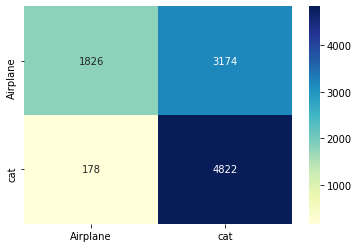

In [9]:
print("Train data report")
print("===================================")
print()


class_names = ['Airplane','cat']
predict_train = np.where(ao > 0.5, 1, 0) 

# confusion matrix

cm = confusion_matrix(Ytr_two, predict_train)

array = cm.tolist()
df_cm = pd.DataFrame(array, index = [i for i in class_names],
                  columns = [i for i in class_names])

sns.heatmap(df_cm, cmap="YlGnBu",annot=True, fmt="d")

print("Accurecy")
print("--------------------------")
print(accuracy_score(Ytr_two, predict_train))
print()

print("Classification report")
print("--------------------------")
print(classification_report(Ytr_two, predict_train, target_names=class_names))




Test data report

Accurecy
--------------------------
0.5325

Classification report
--------------------------
              precision    recall  f1-score   support

    Airplane       0.52      1.00      0.68      1000
         cat       0.97      0.07      0.13      1000

    accuracy                           0.53      2000
   macro avg       0.74      0.53      0.40      2000
weighted avg       0.74      0.53      0.40      2000



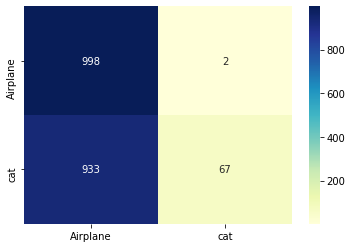

In [10]:
print("Test data report")
print("===================================")
print()


zh_test = np.dot(Xte_rows_two_norm, wh)
ah_test = sigmoid(zh_test)

zo_test = np.dot(ah_test, wo)
ao_test = sigmoid(zo_test)

class_names = ['Airplane','cat']
predict_test = np.where(ao_test > 0.5, 1, 0)   

# confusion matrix
cm = confusion_matrix(Yte_two, predict_test)

array = cm.tolist()
df_cm = pd.DataFrame(array, index = [i for i in class_names],
                  columns = [i for i in class_names])

sns.heatmap(df_cm, cmap="YlGnBu",annot=True, fmt="d")

print("Accurecy")
print("--------------------------")
print(accuracy_score(Yte_two, predict_test))
print()

print("Classification report")
print("--------------------------")
print(classification_report(Yte_two, predict_test, target_names=class_names))